# **Download Libraries**

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-t_d7dvlu
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-t_d7dvlu
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=08bc33ac2f904747b6954c02388939f86e181b6a65403275d39d35a739678941
  Stored in directory: /tmp/pip-ephem-wheel-cache-rlgr6ng2/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [3]:
!pip install h5py

# **Import Libraries**

In [1]:
from tensorflow import keras
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import load
import matplotlib.pyplot as plt 
import cv2

In [3]:
from keras import backend as K
from keras.layers import Activation

In [6]:
import numpy as np

# **Load X-ray Images**

In [4]:
# load all images in a directory into memory
def load_images(path, size=(256, 256)):
    image_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = np.expand_dims(cv2.cvtColor(pixels.astype('uint8'), cv2.COLOR_BGR2GRAY), axis=-1)
        # store
        image_list.append(pixels)
    return asarray(image_list)

In [7]:
# Load normal X-ray images
path_normal = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
data_normal = load_images(path_normal)
print('Successfully Loaded normal X-ray imageset')

Successfully Loaded normal X-ray imageset


In [ ]:
# Load X-ray images of patients with Bacterial Pneumonia
path_pn = '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'
data_pn = load_images(path_pn)
print('Successfully Loaded X-ray images of Bacterial Pneumonia patients')

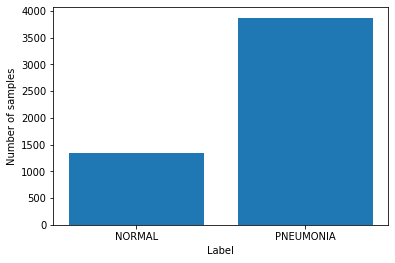

In [16]:
labels = ['NORMAL', 'PNEUMONIA']
size = [len(data_normal), len(data_pn)]
plt.bar(labels, size)
plt.xlabel('Label')
plt.ylabel('Number of samples')

plt.show()

Solve Imbalance using CycleGAN

# **Data Augmentation**

**CLAHE (Contrast Limiting Histogram Equalization)**

In [17]:
def clahe(imgs):
    processed = []
    clahe = cv2.createCLAHE(clipLimit=1.4, tileGridSize=(8,8))
    for i in range(len(imgs)):
        processed.append(np.expand_dims(clahe.apply(imgs[i]), axis=-1))
    return processed

In [18]:
def display_x_ray(data1, data2):
    plt.figure(figsize = (20, 20))
    plt.subplot(1, 2, 1)
    plt.title("NORMAL")
    plt.imshow(data1[0], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("PNEUNOMIA")
    plt.imshow(data2[0], cmap='gray')

    plt.show()

**Before applying CLAHE on Normal and Pneunomia sample**

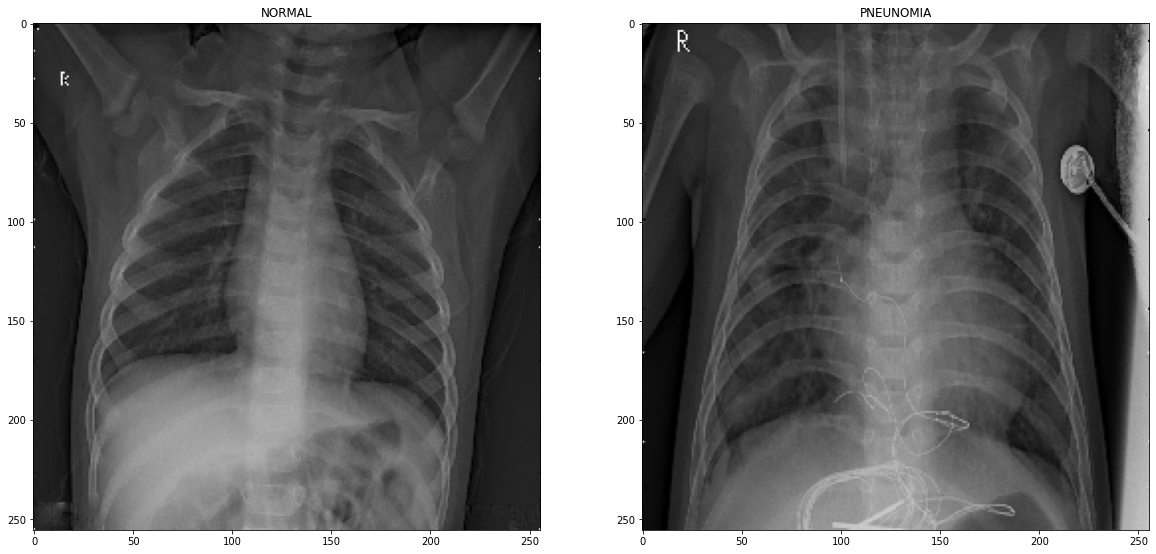

In [19]:
display_x_ray(data_normal, data_pn)

In [20]:
data_normal_clahe = clahe(data_normal)
data_pn_clahe = clahe(data_pn)

**After applying CLAHE on Normal and Pneunomia samples**

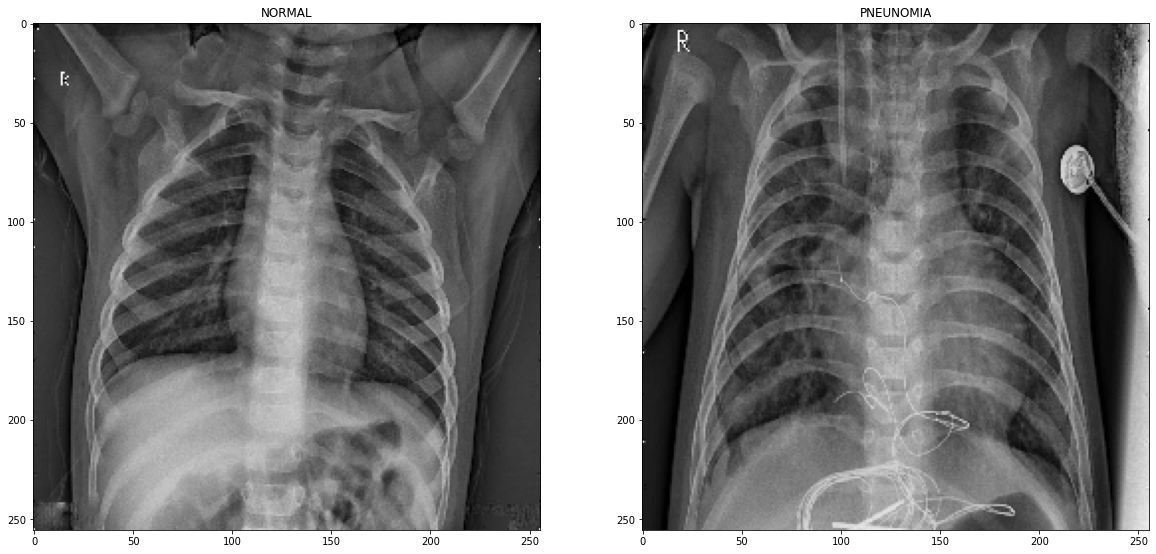

In [21]:
display_x_ray(data_normal_clahe, data_pn_clahe)

In [1]:
#Gaussian Blur and Sharpness Control?
#Equalize sharpness, brightness, contrast across classes and then randomize them within in class for robust model?
#use OCR to remove texts (stats on the top of x-ray images) from x-ray images and do gaussian smoothing on removed parts.
#Train LLM and unlearn the samples that the model perform poorly at the end of training to make model certainly stupid on those prompts and avoid negative effect of hallucination. Then, train other model on those unlearned samples.
#train encoder model as a router that tells whether a prompt of insert might fit to the prompts trained on main model or ones trained on alternative model (similiarity between encodings)
#during LLM training, give higher weights to set(prompts, responses) which prompts have more specificity (e.x) ask other model to evaluate prompt/is it clear what the prompt is looking for?) to avoid hallucination.
#Ignore the feedback on response from user if the prompt is not very specific enough (clearly, user doens't even know what he really want and doesn't really have standard on what's good response for him may just press likes 
#on responses that "seems" good -> may bring hallucination; only learn from smart use cases in which prompt is very specific.

In [22]:
#comparison of cycleGAN vs random brightness/flip

**CycleGAN to Generate Contrastive Synthetic Samples**

In [51]:
EPOCHS = 100
BATCH_SIZE = 8
SAVE_INTERVAL = 5
IMAGE_SHAPE = (256, 256, 1)
OPTIMIZER = Adam(2e-4, 0.5)
DROPOUT_RATE = 0.3
RAMPUP = 80

In [25]:
import tensorflow as tf

In [31]:
class AdaptiveLoss(tf.keras.losses.Loss):
    def __init__(self, base_loss, weight):
        super().__init__()
        self.base_loss = base_loss
        self.weight = weight

    def call(self, y_true, y_pred):
        return self.weight * self.base_loss(y_true, y_pred)

In [29]:
weight_IdenA = tf.Variable(0.2, trainable=False)
weight_IdenB = tf.Variable(0.2, trainable=False)
weight_CycleA = tf.Variable(0.3, trainable=False)
weight_CycleB = tf.Variable(0.3, trainable=False)

In [32]:
losses = [
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), 8),
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), 8),
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), weight_IdenA),
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), weight_IdenB),
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), weight_CycleA),
    AdaptiveLoss(tf.keras.losses.MeanSquaredError(), weight_CycleB)
]

In [47]:
def linear_rampup(epoch, start_weight, final_weight):
    if epoch >= RAMPUP:
        return end
    return start_weight + (final_weight - start_weight) * (epoch / RAMPUP)

In [34]:
def downsample(layer, num_channel, init):
    layer = Conv2D(num_channel, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer)
    layer = InstanceNormalization(axis=-1)(layer)
    layer = LeakyReLU(alpha=0.3)(layer)
    layer = Dropout(DROPOUT_RATE)(layer)
    return layer

In [35]:
def upsample(layer, num_channel, init):
    layer = Conv2DTranspose(num_channel, (4,4), strides=2, padding='same', kernel_initializer=init)(layer)
    layer = LeakyReLU(alpha = 0.2)(layer)
    layer = InstanceNormalization(axis=-1)(layer)
    layer = Dropout(DROPOUT_RATE)(layer)
    return layer

In [36]:
NUM_CHANNELS_DISC = [64, 128, 256, 512]
def discriminator():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input and set it as initial layer
    in_image = Input(shape=IMAGE_SHAPE)
    layer = in_image
    for num_channel in NUM_CHANNELS_DISC:
        layer = downsample(layer, num_channel, init)

    patch_out = Conv2D(1, (3,3), padding='same', kernel_initializer=init)(layer)
    # define model
    model = Model(in_image, patch_out)
    return model

In [37]:
NUM_CHANNELS_GEN = [128, 512]
def generator():
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=IMAGE_SHAPE)
    layer = in_image
    layer_stack = []

    layer = downsample(layer, 64, init)
    for num_channel in NUM_CHANNELS_GEN:
        layer = downsample(layer, num_channel, init)
        layer_stack.append(layer)
        
    # bottleneck
    layer = downsample(layer, 1024, init)
    
    for num_channel in NUM_CHANNELS_GEN[::-1]:
        layer = upsample(layer, num_channel, init)
        layer = Concatenate()([layer, layer_stack.pop()])
    layer = upsample(layer, 64, init)

    # --- Output ---
    out_image = Conv2DTranspose(1, (4,4), strides=2, padding='same', activation='tanh', kernel_initializer=init)(layer)

    return Model(in_image, out_image) 


In [38]:
def augmented_data(image_train_set):
    images = np.empty((len(image_train_set), 256, 256, 1))
    i = 0
    for image in image_train_set:
        random_num = np.random.random()
        if random_num < 0.3:
            single_image = np.fliplr(image)
        elif (random_num > 0.3 and random_num < 0.6):
            single_image = np.flipud(image)
        images[i, :, :, :] = image
        i += 1
    indices = np.random.permutation(len(images))
    return images[indices]

In [39]:
class CycleGAN:
    def __init__(self, discA, discB, genAB, genBA, dataset):
        self.discA = discA
        self.discB = discB
        self.genAB = genAB
        self.genBA = genBA
        self.imgs_A = dataset[0]
        self.imgs_B = dataset[1]
        self.combined = None
        self.discriminator_loss = []
        self.generator_loss = []
        self.min_length = min(len(self.imgs_A), len(self.imgs_B))
        self.n_iterations_per_epoch = self.min_length // BATCH_SIZE

    def save_generation_log(self, epoch):

        img_A = self.imgs_A[0]
        img_B = self.imgs_B[0]

        fake_img_B = self.genAB.predict(self.imgs_A[:1])[0]
        fake_img_A = self.genBA.predict(self.imgs_B[:1])[0]
    
        fake_img_A = 127.5*fake_img_A + 127.5
        fake_img_B = 127.5*fake_img_B + 127.5

        imgs_to_display = [img_A, img_B, fake_img_A, fake_img_B]

        for i in range(len(imgs_to_display)):
            #num should be > 0
            pyplot.subplot(2, 2, i+1)
            pyplot.axis('off')
            pyplot.imshow(imgs_to_display[i], cmap='gray')

        filename = f'generated_plot_{epoch}.png' 
        pyplot.savefig(filename)
        pyplot.close()

    def compile(self):
        def compile_each_model(is_disc, model):
            if is_disc:
                model.compile(
                    loss = "mse",
                    optimizer = OPTIMIZER,
                    metrics = ["accuracy"]
                )
                return
            model.compile(
                loss = "binary_crossentropy",
                optimizer = OPTIMIZER
            )
        compile_each_model(True, self.discA)
        compile_each_model(True, self.discB)
        compile_each_model(False, self.genAB)
        compile_each_model(False, self.genBA)

        input_A = Input(shape = IMAGE_SHAPE)
        input_B = Input(shape = IMAGE_SHAPE)

        fake_A = self.genBA(input_B)
        fake_B = self.genAB(input_A)

        recon_A = self.genBA(fake_B)
        recon_B = self.genAB(fake_A)

        valid_A = self.discA(fake_A)
        valid_B = self.discB(fake_B)

        self.discA.trainable = False
        self.discB.trainable = False

        self.combined = Model(
                [input_A, input_B],
                [valid_A, valid_B, fake_A, fake_B, recon_A, recon_B])
        self.combined.compile(
            loss = losses,
            optimizer = OPTIMIZER)

        self.combined.summary()

    def train(self):
        for epoch in range(EPOCHS):
            #randomly shuffles data, placing the list of different images in first min_size elements of both imgs_A and imgs_B
            self.imgs_A = augmented_data(self.imgs_A)
            self.imgs_B = augmented_data(self.imgs_B)

            fake_B = self.genAB.predict(self.imgs_A)
            fake_A = self.genBA.predict(self.imgs_B)

            valid = np.ones((BATCH_SIZE,) + (16, 16, 1))
            fake = np.zeros((BATCH_SIZE,) + (16, 16, 1))

            weight_IdenA = linear_rampup(epoch, 0.2, 2)
            weight_IdenB = linear_rampup(epoch, 0.2, 2)
            weight_CycleA = linear_rampup(epoch, 0.3, 8)
            weight_CycleB = linear_rampup(epoch, 0.3, 8)
            
            i = 0
            for it in range (0, self.n_iterations_per_epoch):
                imgs_A_p = self.imgs_A[i : i+BATCH_SIZE]
                fake_A_p = fake_A[i : i+BATCH_SIZE]
                imgs_B_p = self.imgs_B[i : i+BATCH_SIZE]
                fake_B_p = fake_B[i : i+BATCH_SIZE]

                dA_loss_real, dA_acc_real = self.discA.train_on_batch(imgs_A_p, valid)    
                dA_loss_fake, dA_acc_fake = self.discA.train_on_batch(fake_A_p, fake)
        
                dB_loss_real, dB_acc_real = self.discB.train_on_batch(imgs_B_p, valid)
                dB_loss_fake, dB_acc_fake = self.discB.train_on_batch(fake_B_p, fake)
                
                g_loss = self.combined.train_on_batch([imgs_A_p, imgs_B_p], [valid, valid, imgs_B_p, imgs_A_p, imgs_A_p, imgs_B_p])
                total_loss, adv_A_loss, adv_B_loss, iden_A_loss, iden_B_loss, recon_A_loss, recon_B_loss = g_loss

                i += BATCH_SIZE
                
            dA_loss = np.add(dA_loss_real, dA_loss_fake) / 2
            dB_loss = np.add(dB_loss_real, dB_loss_fake) / 2
            d_loss = np.add(dA_loss, dB_loss) / 2

            dA_acc = np.add(dA_acc_real, dA_acc_fake) / 2
            dB_acc = np.add(dB_acc_real, dB_acc_fake) / 2
            d_acc = np.add(dA_acc, dB_acc) / 2

            adv_loss = np.add(adv_A_loss, adv_B_loss) / 2
            iden_loss = np.add(iden_A_loss, iden_B_loss) / 2
            recon_loss = np.add(recon_A_loss, recon_B_loss) / 2
    
            print ("Epoch: %d \n disc_loss: %s disc_acc: %s \n gen_total_loss: %s gen_adv: %s gen_iden: %s gen_recon: %s" % (epoch, d_loss, d_acc, total_loss, adv_loss, iden_loss, recon_loss))
            
            self.discriminator_loss.append(d_loss)
            self.generator_loss.append(g_loss)

            if epoch % SAVE_INTERVAL == 0:
                self.save_generation_log(epoch)

        np.save("epoch_%s_d_loss_%s.npy" % (epoch, epoch), self.discriminator_loss)
        np.save("epoch_%s_g_loss_%s.npy" % (epoch, epoch), self.generator_loss)

        self.genAB.save("genAB_%s.h5" % epoch)
        self.genAB.save("genBA_%s.h5" % epoch)

        self.discA.save("discA_%s.h5" % epoch)
        self.discB.save("discB_%s.h5" % epoch)


In [40]:
np.array(data_normal_clahe).shape

(1341, 256, 256, 1)

In [41]:
# load and prepare training images
def scale(dataset):
    X1, X2 = dataset[0], dataset[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [42]:
def form_dataset(dataA, dataB):
    dataset = [np.array(dataA), np.array(dataB)]
    dataset = scale(dataset)
    return dataset

In [50]:
discNormal = discriminator()
discBac = discriminator()
genNormToBac = generator()
genBacToNorm = generator()

cycleGAN = CycleGAN(discNormal, discBac, genNormToBac, genBacToNorm, 
                    form_dataset(data_normal_clahe, data_pn_clahe))
cycleGAN.compile()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 256, 256, 1)  20325505    input_13[0][0]                   
                                                                 model_7[0][0]                    
__________________________________________________________________________________________________
model_7 (Functional)            (None, 256, 256, 1)  20325505    input_12[0][0]             

In [ ]:
cycleGAN.train()

Epoch: 0 
 disc_loss: 0.18895933404564857 disc_acc: 0.85107421875 
 gen_total_loss: 2.4675774574279785 gen_adv: 1.1458995938301086 gen_iden: 0.033641014248132706 gen_recon: 0.054248079657554626
Epoch: 2 
 disc_loss: 0.04916577972471714 disc_acc: 0.980224609375 
 gen_total_loss: 0.8189715147018433 gen_adv: 0.374466672539711 gen_iden: 0.012321152724325657 gen_recon: 0.022697937674820423
Epoch: 3 
 disc_loss: 0.03299609664827585 disc_acc: 0.9893798828125 
 gen_total_loss: 0.5756157636642456 gen_adv: 0.25584933906793594 gen_iden: 0.011038702446967363 gen_recon: 0.020919831469655037
Epoch: 4 
 disc_loss: 0.02627541497349739 disc_acc: 0.993896484375 
 gen_total_loss: 0.48219913244247437 gen_adv: 0.2121417447924614 gen_iden: 0.010043325601145625 gen_recon: 0.018914487212896347
Epoch: 5 
 disc_loss: 0.01912066270597279 disc_acc: 0.99853515625 
 gen_total_loss: 0.37154069542884827 gen_adv: 0.1617662012577057 gen_iden: 0.008726411731913686 gen_recon: 0.015277731698006392
Epoch: 6 
 disc_loss: 0.

# **Evaluate with Pre-trained Models**

In [88]:
from keras.models import load_model
from numpy import expand_dims
import numpy as np 

In [89]:
from keras.applications.resnet import ResNet50 
from keras.models import Model 
from keras.layers import Dense 
from keras.layers import Flatten, Dropout
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [90]:
def load_image(filename, size=(256,256)):
    # load and resize the image
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # transform in a sample
    pixels = expand_dims(pixels, 0)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    return pixels

**Load Cyclic Generators**

In [73]:
cust = {'InstanceNormalization': InstanceNormalization}

In [74]:
#Normal -> Bacterial Synthetic Sample Generator
nb_aug_generator = load_model('../input/normtobac-aug/NormtoBac_aug.h5', cust)

In [79]:
#Bacterial -> Normal Synthetic Sample Generator
bn_aug_generator = load_model('../input/bactonorm-aug/BactoNorm_aug.h5', cust)

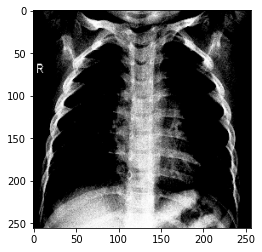

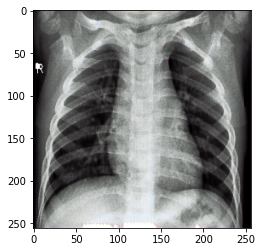

In [80]:
# load the image
image_src = load_image('../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test/Normal/0105.jpeg')
# load Normal->Bacterial Generator
image_tar = nb_aug_generator.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
#plot original image (CLAHE-applied Normal Image)
pyplot.imshow(image_src[0])
pyplot.show()
# plot the translated image (Synthetically Generated Bacterial)
pyplot.imshow(image_tar[0])
pyplot.show()

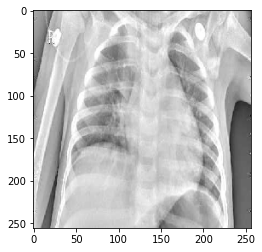

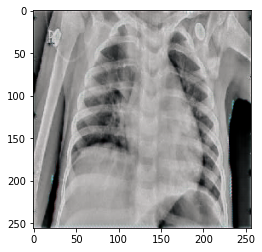

In [82]:
# load the image
image_src = load_image('../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test/Bacterial Pneumonia/116.jpeg')
# load the model

image_tar = bn_aug_generator.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
#plot original image (Bacterial Image without CLAHE)
pyplot.imshow(image_src[0])
pyplot.show()
# plot the translated image (Synthetically Generated Bacterial)
pyplot.imshow(image_tar[0])
pyplot.show()

In [19]:
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

**Load Validation Dataset**

In [ ]:
norm_data, bac_data = load_real_samples('../input/xrayaugval/x_ray_aug_val.npz')

In [ ]:
def select_sample(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    return X

**Translate the negative to positive samples, and vice versa**

In [ ]:
selected_norm = select_sample(norm_data, 30)
norm_to_bac = nb_aug_generator.predict(selected_norm) 

In [ ]:
selected_bac = select_sample(bac_data, 30)
bac_to_norm = bn_aug_generator.predict(selected_bac)

**Concatenate the validation imageset with the translated images to finalize augmentation**

In [ ]:
bac_data_p = np.concatenate([bac_data, norm_to_bac], axis=0)
print('Before Adding Generated Samples: ' , bac_data.shape) 
print('After Adding Generated Samples: ' , bac_data_p.shape)

In [ ]:
norm_data_p = np.concatenate([norm_data, bac_to_norm], axis=0)
print('Before Adding Generated Samples: ' , norm_data.shape) 
print('After Adding Generated Samples: ' , norm_data_p.shape)

In [ ]:
#training set 
X = np.concatenate([bac_data, norm_data], axis=0)
y = np.concatenate([ones(bac_data.shape[0]), zeros(norm_data.shape[0])], axis=0)

In [ ]:
X_p = np.concatenate([bac_data_p, norm_data_p], axis=0)
y_p = np.concatenate([ones(bac_data_p.shape[0]), zeros(norm_data_p.shape[0])], axis=0)

In [ ]:
def scale(dataset):
    for i in range(len(dataset)): 
        dataset[i] = (dataset[i] + 1) / 2.0
    return dataset 

In [ ]:
X = scale(X) 

In [ ]:
X_p = scale(X_p)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

In [ ]:
model = ResNet50(include_top=False, input_shape=(256, 256, 3), weights="imagenet") 
model.trainable = False
flat1 = Flatten()(model.layers[-1].output) 
class1 = Dropout(0.1)(flat1)
class1 = Dense(1024, activation='relu')(class1)
class1 = Dropout(0.1)(class1)
output = Dense(1, activation='sigmoid')(class1)
model = Model(inputs=model.inputs, outputs=output)
model_p = Model(inputs=model.inputs, outputs=output)
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.007), metrics=['Accuracy'])
model_p.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.007), metrics=['Accuracy'])

In [ ]:
history = model_p.fit(X_train, y_train, epochs=45, batch_size=50, shuffle=True, validation_data=(X_test, y_test))

In [ ]:
model_p.save('CLAHE+CycleGAN+ResNet_30.h5')

In [ ]:
np.save('CLAHE+CycleGAN+Resnet_30.npy',history.history)

In [5]:
control_history=np.load('../input/resnet-history/Resnet.npy',allow_pickle='TRUE').item()

In [6]:
experimental_val_history=np.load('../input/clahe-cycleganresnet1415/clahe_cycleGanResNet_14_15.npy',allow_pickle='TRUE').item()

In [7]:
experimental_wc_history = np.load('../input/cycleganresnet/CycleGANResnet.npy', allow_pickle='TRUE').item()

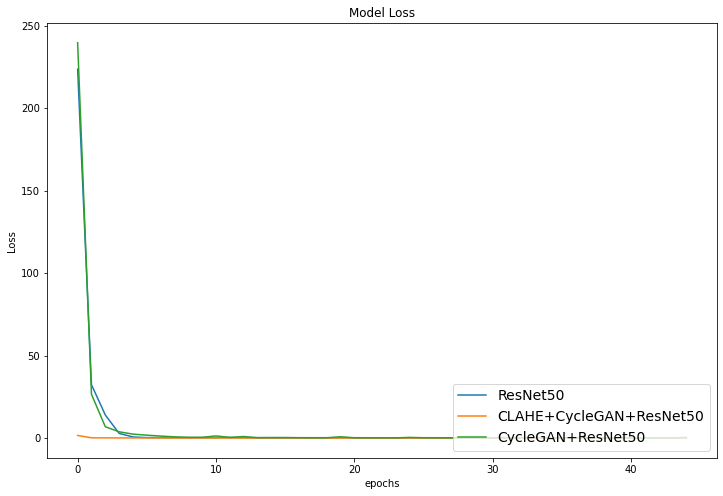

In [9]:
fig = plt.figure(figsize=(12,8))
plt.plot(control_history['loss'])
plt.plot(experimental_val_history['loss'])
plt.plot(experimental_wc_history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['ResNet50', 'CLAHE+CycleGAN+ResNet50', 'CycleGAN+ResNet50'], loc='lower right', fontsize=14)
plt.show()
fig.savefig('Model_Loss.jpg')

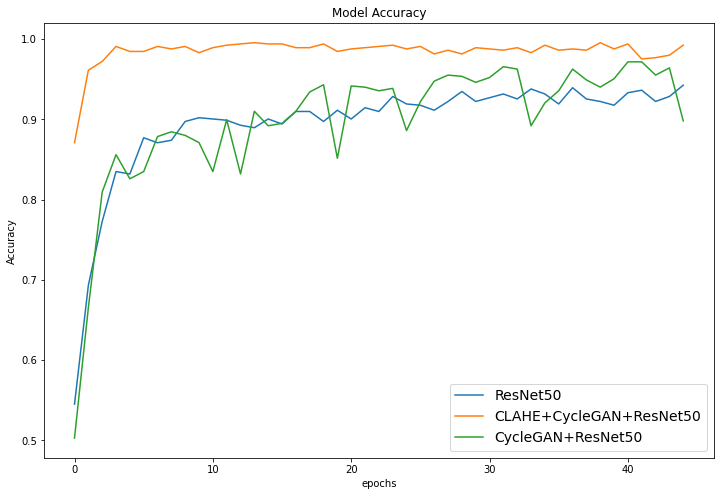

In [10]:
fig = plt.figure(figsize=(12,8))
plt.plot(control_history['Accuracy'])
plt.plot(experimental_val_history['Accuracy'])
plt.plot(experimental_wc_history['Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['ResNet50', 'CLAHE+CycleGAN+ResNet50', 'CycleGAN+ResNet50'], loc='lower right', fontsize=14)
plt.show()
fig.savefig('Model_Loss.jpg')